## Cross validation in the context of time series


Pour les séries de données temporelles, nous ne pouvons pas utiliser les outils classiques de validation croisée, simplement parce que l'ordre de l'ensemble de données a beaucoup d'importance. En fait, une procédure de validation croisée standard créera beaucoup de fuites de données car elle utilisera des données du futur pour prédire le passé. C'est pourquoi nous avons besoin d'un schéma spécifique comme celui ci-dessus.


La classe TimeSeriesSplit de Scikit-learn fournit des indices train/test pour diviser les échantillons de données de séries temporelles. À chaque division, les indices de test doivent être plus élevés qu'avant, et le brassage dans le validateur croisé est donc inapproprié.

Cet objet de validation croisée est une variation de KFold. Dans la kième division, il retourne les k premiers folds comme ensemble d'entraînement et le (k+1) ième fold comme ensemble de test.

Notez que, contrairement aux méthodes de validation croisée standard, les ensembles d'entraînement successifs sont des surensembles de ceux qui les précèdent. Ainsi, pour une instance TimeSeriesSplit(n_splits=5), on obtient la validation croisée suivante :

- TRAIN: [0] TEST: [1]
- TRAIN: [0 1] TEST: [2]
- TRAIN: [0 1 2] TEST: [3]
- TRAIN: [0 1 2 3] TEST: [4]
- TRAIN: [0 1 2 3 4] TEST: [5]

## Hyperparameters tuning : GS vs RS vs BO

Gridsearch n'est pas très souvent utilisée dans la pratique, car le nombre de modèles à entraîner croît de manière exponentielle lorsque le nombre d'hyperparamètres à entraîner augmente. Cela peut être très inefficace, tant en termes de puissance de calcul que de temps.

Randomsearch diffère en ce sens que nous ne fournissons plus un ensemble explicite de valeurs pour chaque hyperparamètre mais une distribution statistique pour chaque hyperparamètre à partir de laquelle les valeurs sont échantillonnées. Essentiellement, nous définissons une distribution d'échantillonnage pour chaque hyperparamètre afin d'effectuer une recherche aléatoire (exponentielle, lognormal, normal, uniform, loguniform...).

Dans les deux méthodes précédentes, nous avons réalisé des expériences individuelles en construisant plusieurs modèles avec différentes valeurs d'hyperparamètres. Toutes ces expériences étaient indépendantes les unes des autres. Comme chaque expérience a été réalisée indépendamment, nous ne sommes pas en mesure d'utiliser les informations d'une expérience pour améliorer l'expérience suivante.

A contrario, l'optimisation bayésienne est un algorithme d'optimisation séquentielle basée sur un modèle qui utilise les résultats de l'itération précédente pour décider des prochaines valeurs candidates des hyperparamètres.

Ainsi, au lieu de rechercher aveuglément l'espace des hyperparamètres, cette méthode préconise l'utilisation des expériences précédentes pour choisir le prochain ensemble d'hyperparamètres qui améliorera la performance du modèle. Nous répétons ce processus de manière itérative jusqu'à ce que nous convergions vers un optimum.

Enfin, l'optimisation de Parzen arborescente (TPE) est similaire à celle de l'optimisation bayésienne. Au lieu de trouver les valeurs de p(y|x) où y est la fonction à minimiser et x est la valeur de l'hyperparamètre, le TPE modélise P(x|y) et P(y). L'un des grands inconvénients des estimateurs de Parzen structurés en arbre est qu'ils ne modélisent pas les interactions entre les hyperparamètres. Cela dit, le TPE fonctionne extrêmement bien en pratique et a été testé dans la plupart des domaines. 

Ici, pour des raisons de puissance de calcul mais aussi de performance, nous utilisons l'optimisation bayésienne.

In [1]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import pandas as pd 
import numpy as np 
import pickle


train = pd.read_csv('../data/train.csv', index_col='date')
test = pd.read_csv('../data/test.csv', index_col='date')

In [2]:
y_train = train.reel
X_train = train.drop(['reel'], axis=1)
y_test = test.reel
X_test = test.drop(['reel'], axis=1)

In [4]:
X_train.columns

Index(['prevision', 'cantine_nom', 'annee_scolaire', 'effectif',
       'quartier_detail', 'prix_quartier_detail_m2_appart',
       'prix_moyen_m2_appartement', 'prix_moyen_m2_maison', 'longitude',
       'latitude', 'depuis_vacances', 'depuis_ferie', 'depuis_juives',
       'ramadan_dans', 'depuis_ramadan', 'year', 'day_of_week_sin',
       'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'freq_reel_%',
       'freq_reel_%_std'],
      dtype='object')

In [6]:
# perform time series split

cv_ts = TimeSeriesSplit(n_splits=2)

L'optimisation consiste à trouver la valeur d'entrée ou l'ensemble de valeurs d'une fonction objectif qui donne la valeur de sortie la plus faible, appelée "perte". En général, dans l'apprentissage automatique, notre fonction objective est multidimensionnelle car elle prend en compte un ensemble d'hyperparamètres du modèle.

Pour les modèles dont l'apprentissage prend plusieurs jours, nous voulons un moyen de limiter les appels à la fonction d'évaluation. La recherche aléatoire est en fait plus efficace que la recherche sur grille pour les problèmes à haute dimension, mais il s'agit toujours d'une méthode uniforme où la recherche n'utilise pas les résultats précédents pour choisir les prochaines valeurs d'entrée à essayer. 

L'optimisation bayésienne, également appelée optimisation séquentielle basée sur un modèle (SMBO), met en œuvre cette idée d'apprentissage par l'expérience en construisant un modèle de probabilité de la fonction objectif qui associe les valeurs d'entrée à une probabilité de perte : p (perte | valeurs d'entrée). 

Le modèle de probabilité, également appelé surrogate, est plus facile à optimiser que la fonction objectif réelle. Le concept consiste à limiter les évasions de la fonction objective en passant plus de temps à choisir les prochaines valeurs à essayer.

Les choix courants de surrogate incluent les processus gaussiens, la régression Random Forest, et, le choix dans Hyperopt, l'estimateur Tree Parzen (TPE).

La formulation d'un problème d'optimisation dans Hyperopt nécessite quatre parties :
- Fonction objective : prend une entrée et renvoie une perte à minimiser.
- Espace du domaine : la gamme de valeurs d'entrée à évaluer.
- Algorithme d'optimisation : la méthode utilisée pour construire la fonction de substitution et choisir les prochaines valeurs à évaluer.
- Résultats : score, paires de valeurs que l'algorithme utilise pour construire le modèle.
 

In [64]:
# Optimization objective
def cv_score(max_depth, n_estimators, eta,  gamma):

    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'n_estimators': int(n_estimators),
              'eta': eta,
              'gamma': gamma}

    score = cross_val_score(
        XGBRegressor(**params,
                         scoring='neg_mean_squared_error',
                         cv=cv_ts, n_jobs=-1), X_train, y_train, n_jobs=-1).mean()

    return score = np.array(score)


optimizer = BayesianOptimization(cv_score, {'max_depth': (3, 7),
                                            'eta': (0, 0.3),
                                            'n_estimators': (50, 500),
                                            'gamma': (0, 1)})


# Use expected improvement acquisition function to handle negative numbers
# needs quite a few more initiation points and number of iterations
optimizer.maximize(init_points=3, n_iter=10, acq='ei')

|   iter    |  target   |    eta    |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.956    |  0.2614   |  0.06776  |  4.863    |  368.8    |
|  2        |  0.9637   |  0.06828  |  0.5474   |  4.333    |  195.4    |
|  3        |  0.9633   |  0.1491   |  0.8501   |  3.045    |  226.4    |
|  4        |  0.9634   |  0.2251   |  0.2347   |  3.065    |  78.04    |
|  5        |  0.964    |  0.08854  |  0.8799   |  3.064    |  136.3    |
|  6        |  0.9567   |  0.2495   |  0.7831   |  6.992    |  153.4    |
|  7        |  0.9499   |  0.2693   |  0.1507   |  5.551    |  468.3    |
|  8        |  0.9609   |  0.2052   |  0.4348   |  4.065    |  225.3    |
|  9        |  0.961    |  0.2613   |  0.486    |  3.084    |  229.8    |
|  10       |  0.9633   |  0.1178   |  0.9844   |  4.545    |  133.8    |
|  11       |  0.9621   |  0.06833  |  0.4562   |  6.117    |  137.7    |
|  12       |  0.9588   |  0.1339   | 

Comparons maintenant l'optimisation d'XGBoost par random search et par bayesian search.

La meilleur itération est la suivante : 
|  5        |  0.964    |  0.08854  |  0.8799   |  3.064    |  136.3    |


In [127]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.8799, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08854, max_delta_step=0, max_depth=3,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=136, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.8799, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08854, max_delta_step=0, max_depth=3,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=136, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def print_metrics(y_true, y_predicted):

    print('Root Mean Square Error            = ' +
          str(np.sqrt(mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error               = ' +
          str(mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error             = ' +
          str(median_absolute_error(y_true, y_predicted))) 

y_pred = xgb.predict(X_test)
print_metrics(y_test**2, y_pred**2)

In [135]:
y_pred = models['best_xgbr'].predict(X_test)
print(models['best_xgbr'], '\n')
print_metrics(y_test**2, y_pred**2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=95, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 

Root Mean Square Error            = 22.122820724498332
Mean Absolute Error               = 16.154971986274795
Median Absolute Error             = 12.76448690834031


In [136]:
y_pred = models['best_lgbr'].predict(X_test)
print(models['best_lgbr'], '\n')
print_metrics(y_test**2, y_pred**2)

LGBMRegressor(max_depth=5, n_estimators=150, num_leaves=8) 

Root Mean Square Error            = 22.094410468949704
Mean Absolute Error               = 15.99914128977054
Median Absolute Error             = 12.415289455391928


<b> Les résultats sont globalement identique par rapport à la randomized search, la technique est cependant plus complexe à prendre en main et davantage de tuning est requis. Pour notre cas ici présent, nous continuerons à privilégier randomized serach.

## Optimisation des autres modèles selectionnées

Nous avons déjà optimisé XGBoost et LightGBM avec de bons résultats.

Travaillons sur les modèles restants selectionnés par notre package: 

- ElasticNet et LassoLars
- Multilayer perceptron
- Decision Tree
- Random Forest

In [69]:
# random forest regressor opti

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

params = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 20, num = 4)],
               'min_samples_split': [2, 5, 10, 20, 50],
               'min_samples_leaf': [2, 5, 10]}

reg = RandomForestRegressor(random_state=42)

n_iter_search = 50
random_search = RandomizedSearchCV(reg, param_distributions=params, verbose = 2,
                                   n_iter=n_iter_search, cv=cv_ts, scoring='neg_mean_squared_error', random_state=42)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=  12.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=  26.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   2.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   5.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=

[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=  26.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=  56.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  58.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.2min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   5.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=  11.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=  25.7s
[CV] END max_depth=15, max_feature

In [139]:
rfr = RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42)

In [140]:
y_pred = rfr.predict(X_test)
print(models['best_rfr'], '\n')
print_metrics(y_test**2, y_pred**2)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42) 

Root Mean Square Error            = 22.321157258083485
Mean Absolute Error               = 16.328702116714958
Median Absolute Error             = 13.110574435795854


In [81]:
pickle.dump(rfr, open('models/best_rfr.sav', 'wb'))

In [91]:
# decision tree regressor opti

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

parameters = {"splitter": ["best", "random"],
              "max_depth": [3, 5, 7, 10],
              "min_samples_leaf": [5, 10, 20, 40],
              "min_weight_fraction_leaf": [0.1, 0.3, 0.5, 0.7, 0.9],
              "max_leaf_nodes": [None, 10, 20, 50, 70]}

dtr = DecisionTreeRegressor(random_state=42)

grid_cv = GridSearchCV(dtr, parameters, cv=cv_ts, n_jobs=-1, verbose=2)

grid_cv.fit(X_train, y_train)

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


/home/quentin/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 0.90565556  0.13974037  0.77556214  0.00954129 -0.00438794 -0.00415766
         nan         nan         nan         nan  0.90565556  0.13974037
  0.77556214  0.00954129 -0.00438794 -0.00415766         nan         nan
         nan         nan  0.90565556  0.13974037  0.77556214  0.00954129
 -0.00438794 -0.00415766         nan         nan         nan         nan
  0.88906948  0.13974037  0.77556214  0.00954129 -0.00438794 -0.00415766
         nan         nan         nan         nan  0.88906948  0.13974037
  0.77556214  0.00954129 -0.00438794 -0.00415766         nan         nan
         nan         nan  0.88906948  0.13974037  0.77556214  0.00954129
 -0.00438794 -0.00415766         nan         nan         nan         nan
  0.90565556  0.13974037  0.77556214  0.00954129 -0.00438794 -0.00415766
         nan         nan         nan         nan

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [None, 5, 10, 20, 50, 70],
                         'min_samples_leaf': [10, 20, 40],
                         'min_weight_fraction_leaf': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'splitter': ['best', 'random']},
             verbose=2)

In [143]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1, random_state=42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1, random_state=42)

In [144]:
y_pred = dtr.predict(X_test)
print(models['best_dtr'], '\n')
print_metrics(y_test**2, y_pred**2)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1, random_state=42) 

Root Mean Square Error            = 29.815816165202875
Mean Absolute Error               = 18.911018791979842
Median Absolute Error             = 13.561353087245095


In [95]:
# results clearly lack behind, it will not be used for ensembling,
# only for interpretation purposes
pickle.dump(dtr, open('models/best_dtr.sav', 'wb'))

In [6]:
# MLP regressor opti

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

params = {'hidden_layer_sizes': [(16,), (64,), (100,), (32, 64)],
          'activation': ['relu'],
          'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1],
          'learning_rate': ['invscaling', 'adaptive'],
          'tol': [1e-4, 1e-3, 1e-2],
          'warm_start': [True, False],
          'batch_size': ['auto', 50],
          'max_iter': [1000],
          'early_stopping': [True, False],
          'epsilon': [1e-8, 1e-5]
          }

mlpr = MLPRegressor(random_state=42)

n_iter_search = 100
random_search = RandomizedSearchCV(mlpr, param_distributions=params, verbose=2,
                                   n_iter=n_iter_search, cv=cv_ts, scoring='neg_mean_squared_error', random_state=42)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] END activation=relu, alpha=0.1, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=   3.6s
[CV] END activation=relu, alpha=0.1, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   4.7s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   8.5s
[CV] END activation=relu, alpha=0.01, batch_size=50, early_stopping=True, epsilon=1e-05, hidden_layer_sizes=(100,),

[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.01, warm_start=True; total time=   7.9s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.01, warm_start=True; total time=  13.2s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, early_stopping=True, epsilon=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, max_iter=1000, tol=0.0001, warm_start=False; total time=  15.6s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, early_stopping=True, epsilon=1e-05, hidden_layer_sizes=(16,), learning_rate=invscaling, max_iter=1000, tol=0.0001, warm_start=False; total time=   9.9s
[CV] END activation=relu, alpha=1, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, tol=0.001, wa

[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=  31.6s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=  24.9s
[CV] END activation=relu, alpha=0.1, batch_size=50, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=  13.6s
[CV] END activation=relu, alpha=0.1, batch_size=50, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=  22.3s
[CV] END activation=relu, alpha=0.001, batch_size=50, early_stopping=True, epsilon=1e-08, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_star

[CV] END activation=relu, alpha=0.0001, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(64,), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   6.4s
[CV] END activation=relu, alpha=1e-05, batch_size=50, early_stopping=True, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.0001, warm_start=True; total time=  21.8s
[CV] END activation=relu, alpha=1e-05, batch_size=50, early_stopping=True, epsilon=1e-05, hidden_layer_sizes=(32, 64), learning_rate=adaptive, max_iter=1000, tol=0.0001, warm_start=True; total time=  17.2s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_start=True; total time=   3.6s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-05, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, tol=0.001, warm_star

[CV] END activation=relu, alpha=0.0001, batch_size=50, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(16,), learning_rate=adaptive, max_iter=1000, tol=0.0001, warm_start=False; total time=  43.6s
[CV] END activation=relu, alpha=1e-05, batch_size=50, early_stopping=True, epsilon=1e-08, hidden_layer_sizes=(16,), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   3.3s
[CV] END activation=relu, alpha=1e-05, batch_size=50, early_stopping=True, epsilon=1e-08, hidden_layer_sizes=(16,), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   4.5s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(32, 64), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_start=True; total time=   5.1s
[CV] END activation=relu, alpha=0.01, batch_size=auto, early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(32, 64), learning_rate=invscaling, max_iter=1000, tol=0.01, warm_sta

In [147]:
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(alpha=1, batch_size=50, epsilon=1e-05, hidden_layer_sizes=(64,),
             learning_rate='adaptive', max_iter=1000, random_state=42,
             warm_start=True)
mlpr.fit(X_train, y_train)

MLPRegressor(alpha=1, batch_size=50, epsilon=1e-05, hidden_layer_sizes=(64,),
             learning_rate='adaptive', max_iter=1000, random_state=42,
             warm_start=True)

In [149]:
y_pred = mlpr.predict(X_test)
print(models['best_mlpr'], '\n')
print_metrics(y_test**2, y_pred**2)

MLPRegressor(alpha=1, batch_size=50, epsilon=1e-05, hidden_layer_sizes=(64,),
             learning_rate='adaptive', max_iter=1000, random_state=42,
             warm_start=True) 

Root Mean Square Error            = 23.01343321772954
Mean Absolute Error               = 16.58430131205634
Median Absolute Error             = 13.047778247641766


In [15]:
pickle.dump(mlpr, open('models/best_mlpr.sav', 'wb'))

In [60]:
# elasticnet is a combination of both Ridge and lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

elastic = ElasticNet()

parameters = {'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'l1_ratio': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid = GridSearchCV(elastic, param_grid=parameters, cv=cv_ts,
                    scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

Fitting 2 folds for each of 121 candidates, totalling 242 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9],
                         'l1_ratio': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.6,
                                      0.7, 0.8, 0.9, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [150]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.1, l1_ratio=0.8)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.8)

In [151]:
y_pred = elastic.predict(X_test)
print(models['best_elastic'], '\n')
print_metrics(y_test**2, y_pred**2)

ElasticNet(alpha=0.1, l1_ratio=0.8) 

Root Mean Square Error            = 26.293120551346014
Mean Absolute Error               = 19.378523384199774
Median Absolute Error             = 16.168866637912018


In [64]:
pickle.dump(elastic, open('models/best_elastic.sav', 'wb'))

In [86]:
from sklearn.linear_model import LassoLars, Lasso

lassol = LassoLars()

parameters = {'alpha': np.logspace(-5, -0.1, 100)}

grid = GridSearchCV(lassol, param_grid=parameters, cv=cv_ts,
                    scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LassoLars(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 1.12071439e-05, 1.25600075e-05, 1.40761812e-05,
       1.57753789e-05, 1.76796941e-05, 1.98138877e-05, 2.22057091e-05,
       2.48862578e-05, 2.78903873e-05, 3.12571585e-05, 3.50303474e-05,
       3.92590145e-05, 4.39981426e...
       5.77585340e-02, 6.47308204e-02, 7.25447621e-02, 8.13019590e-02,
       9.11162756e-02, 1.02115322e-01, 1.14442111e-01, 1.28256920e-01,
       1.43739377e-01, 1.61090788e-01, 1.80536765e-01, 2.02330151e-01,
       2.26754313e-01, 2.54126822e-01, 2.84803587e-01, 3.19183479e-01,
       3.57713519e-01, 4.00894689e-01, 4.49288448e-01, 5.03524031e-01,
       5.64306628e-01, 6.32426560e-01, 7.08769549e-01, 7.94328235e-01])},
             scoring='neg_mean_squared_error', verbose=2)

In [152]:
lassol = LassoLars(alpha=0.00076)
lassol.fit(X_train, y_train)

LassoLars(alpha=0.00076)

In [13]:
y_pred = lassol.predict(X_test)
print(models['best_lassol'], '\n')
print_metrics(y_test**2, y_pred**2)

In [67]:
pickle.dump(lassol, open('models/best_lassol.sav', 'wb'))

In [5]:
from sklearn.linear_model import LassoLars, Lasso

lass = Lasso(alpha=0.01, random_state=62)
lass.fit(X_train, y_train)

Lasso(alpha=0.01, random_state=62)

In [9]:
pickle.dump(lass, open('models/best_lasso.sav', 'wb'))

In [14]:
y_pred = lass.predict(X_test)
print(models['best_lasso'], '\n')
print_metrics(y_test**2, y_pred**2)

Lasso(alpha=0.01, random_state=62) 

Root Mean Square Error            = 25.703738783164106
Mean Absolute Error               = 18.61978391669346
Median Absolute Error             = 15.55926229391335


Linear models perform worth than tree based or NN, that said, they will brind diversity and uncorrelated predictions for ensembling.

## Ensembling des différents modèles

Il existe différentes techniques d'ensembling :



In [11]:
import glob, re, pickle, os

models = {}
for model in glob.glob("models/*.sav"):
    loaded_model = pickle.load(open(model, 'rb'))
    name = os.path.basename(model)
    name = os.path.splitext(name)[0]
    models[name] = loaded_model
    
models

{'best_lasso': Lasso(alpha=0.01, random_state=62),
 'best_lgbr': LGBMRegressor(max_depth=5, n_estimators=150, num_leaves=8),
 'best_elastic': ElasticNet(alpha=0.1, l1_ratio=0.8),
 'best_lassol': LassoLars(alpha=0.00076),
 'best_rfr': RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=50,
                       n_estimators=300, random_state=42),
 'best_mlpr': MLPRegressor(alpha=1, batch_size=50, epsilon=1e-05, hidden_layer_sizes=(64,),
              learning_rate='adaptive', max_iter=1000, random_state=42,
              warm_start=True),
 'best_dtr': DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                       min_weight_fraction_leaf=0.1, random_state=42),
 'best_xgbr': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=

### 1.Test de la corrélation des prédictions des différents modèles

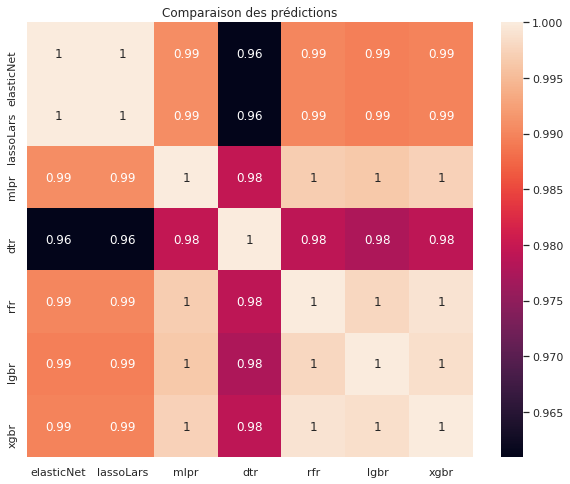

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

pred_best_lgbr = pd.Series(models['best_lgbr'].predict(X_test), name="lgbr")
pred_best_elastic = pd.Series(
    models['best_elastic'].predict(X_test), name="elasticNet")
pred_best_lassol = pd.Series(
    models['best_lassol'].predict(X_test), name="lassoLars")
pred_best_rfr = pd.Series(models['best_rfr'].predict(X_test), name="rfr")
pred_best_mlpr = pd.Series(models['best_mlpr'].predict(X_test), name="mlpr")
pred_best_dtr = pd.Series(models['best_dtr'].predict(X_test), name="dtr")
pred_best_xgbr = pd.Series(models['best_xgbr'].predict(X_test), name="xgbr")

# Concatenate all regressor results
ensemble_res = pd.concat([
    pred_best_elastic, pred_best_lassol, pred_best_mlpr,
    pred_best_dtr, pred_best_rfr, pred_best_lgbr, pred_best_xgbr], axis=1)

plt.figure(figsize=(10,8))
plt.title('Comparaison des prédictions')
g = sns.heatmap(ensemble_res.corr(), annot=True)

Les prédictions sont très corrélées entre les différents modèles, à priori, l'ensembling n'apportera pas de plus value ici. La raison de la corrélation moins forte de l'arbre de décision et simplement sa propension à faire davantage d'erreurs.

### 2. Ensembling techniques (averaging, voting et stacking)

In [95]:
# Simple averaging
ensemble_res['predictions'] = np.mean(ensemble_res[['elasticNet', 'lassoLars', 'mlpr', 'dtr', 'rfr', 'lgbr', 'xgbr']], axis=1)

In [96]:
print_metrics(y_test**2, ensemble_res['predictions']**2)

Root Mean Square Error            = 23.090010282760787
Mean Absolute Error               = 16.84447024156129
Median Absolute Error             = 13.314907886983512


Pas d'améliorations car pas de différence dans les prédictions, essayons le voting.

In [97]:
from sklearn.ensemble import VotingRegressor

ensemble = VotingRegressor([('lgbr', models['best_lgbr']), ('elasticNet', models['best_elastic']),
                                   ('xgbr', models['best_xgbr']), ('mlpr', models['best_mlpr']),
                                   ('rfr', models['best_rfr'])],
                                  n_jobs=-1)

ensemble.fit(X_train, y_train)

In [154]:
y_pred = ensemble.predict(X_test)
print('VotingRegressor:', '\n')
print_metrics(y_test**2, y_pred**2)

VotingRegressor: 

Root Mean Square Error            = 22.61388504828029
Mean Absolute Error               = 16.511757286035905
Median Absolute Error             = 13.115560272803897


Le vote est mieux que le simple averaging mais cela ne parvient pas à battre lightGBM ou XGboost. Essayons le stacking.

In [125]:
from sklearn.ensemble import StackingRegressor

ensemble_s = StackingRegressor([('lgbr', models['best_lgbr']), ('elasticNet', models['best_elastic']),
                                   ('xgbr', models['best_xgbr']), ('mlpr', models['best_mlpr']),
                                   ('rfr', models['best_rfr'])],
                                  final_estimator=Lasso(),
                                  n_jobs=-1)

ensemble_s.fit(X_train, y_train)

StackingRegressor(estimators=[('lgbr',
                               LGBMRegressor(max_depth=5, n_estimators=150,
                                             num_leaves=8)),
                              ('elasticNet',
                               ElasticNet(alpha=0.1, l1_ratio=0.8)),
                              ('xgbr',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1.0, gamma=0.5,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.1, max...
                                            tree_method='exact',
                                            validate_parameters=1,
                                  

In [126]:
y_pred = ensemble_s.predict(X_test)
print_metrics(y_test**2, y_pred**2)

Root Mean Square Error            = 26.333890640845347
Mean Absolute Error               = 18.684786666859047
Median Absolute Error             = 13.05969559820823


C'est une regression par rapport aux modèles de base. Ainsi, il ne sera pas nécessaire d'avoir recours à l'ensembling sur ce jeu de données.

## Bilan de la phase d'optimisation 

Le modèle qui sort gagnant est le lightGBM regressor, légèrement devant XGboost, RandomForest et Multylayer Perceptron. De part la similitude des prédictions, les techniques d'ensemble n'ont pas apporté de gain significatif.

--------------------------------------------------------------------------

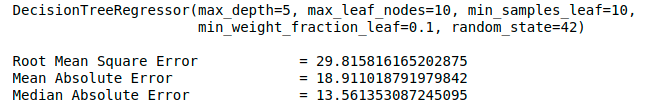

--------------------------------------------------------------------------

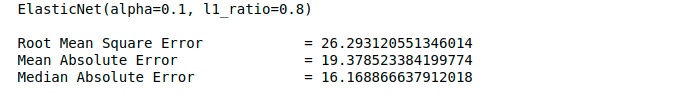

--------------------------------------------------------------------------

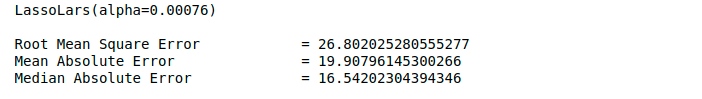

--------------------------------------------------------------------------

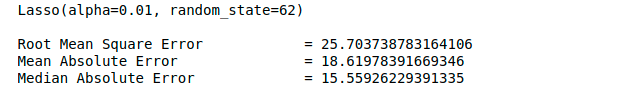

--------------------------------------------------------------------------

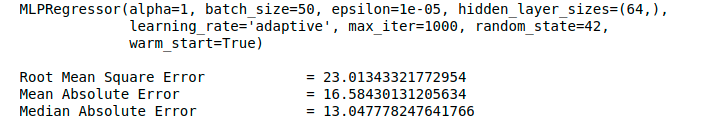

--------------------------------------------------------------------------

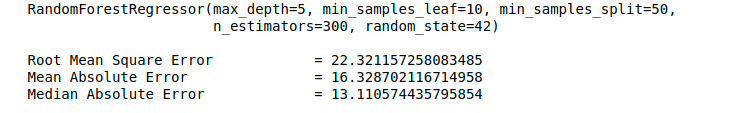

--------------------------------------------------------------------------

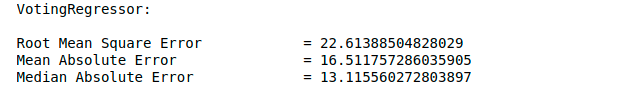

--------------------------------------------------------------------------

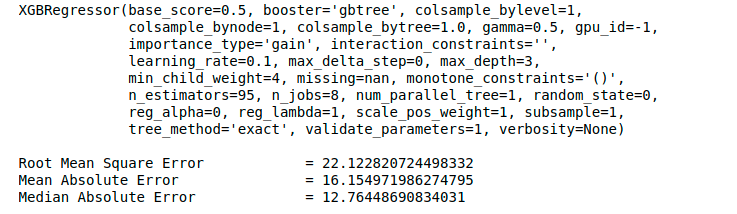

--------------------------------------------------------------------------

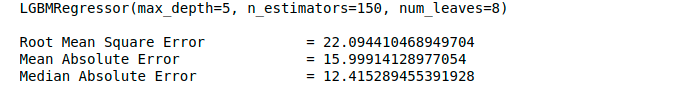

--------------------------------------------------------------------------

